# Mask R-CNN - Inspect Vessels Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [12]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import vessel

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [13]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

print (cpus,gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(cpus[:])
    #tf.config.experimental.set_visible_devices(gpus, 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Configurations

In [15]:
# Dataset directory
DATASET_DIR = "PATH_TO_COCO_DATASET"

# Inference Configuration
config = vessel.VesselInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

## Notebook Preferences

In [16]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [17]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [18]:
# Load validation dataset
dataset = vessel.VesselDataset()
dataset.load_vessel(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=3.36s)
creating index...
index created!
val set: 104
total set: 608
Found 104 images in db val
Images: 104
Classes: ['BG', 'not dilated vessel', 'Intermediately dilated vessel', 'highly dilated vessel', 'CCL21+']


## Load Model

In [19]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          model_dir=LOGS_DIR,
                          config=config)

In [20]:
# Load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/jovyan/cavenel/aktwelve_mask_rcnn/logs/vessels20201022T1513/mask_rcnn_vessels_0546.h5
Re-starting from epoch 546


## Run Detection

In [25]:
from collections import defaultdict    
import itertools
def count_prediction(gt_class_ids, pred_class_ids,
                  overlaps, class_names, threshold=0.5):
    """Count the number of ground truth objects are corrected classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs   
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictions and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    #print (overlaps.shape, len(gt_class_ids), len(pred_class_ids), len(class_names))
    #inspect_class = defaultdict(set)
    inspect_class = defaultdict(int)
    
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]
    
    thresh = overlaps.max() / 3.
    missed = list(range(len(gt_class_ids)))
    wrong = list(range(len(gt_class_ids)))
    matrix = np.zeros((3,4)).astype(np.uint8)
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):        
        if overlaps[i, j] > thresh:
            if j in missed:
                missed.remove(j)
            matrix[gt_class_ids[j]-1, pred_class_ids[i]-1] += 1
            if gt_class_ids[j] == pred_class_ids[i]:
                if j in wrong:
                    wrong.remove(j)
                #inspect_class[class_names[gt_class_ids[j]]].add(overlaps[i, j])
                inspect_class[gt_class_ids[j]] += 1
    for k in missed:
        wrong.remove(k)
        matrix[gt_class_ids[j]-1, -1] += 1
    missed = [gt_class_ids[k] for k in missed]
    missed = {k:missed.count(k) for k in [1,2,3]}
    wrong =  [gt_class_ids[k] for k in wrong]
    wrong =  {k:wrong.count(k) for k in [1,2,3]}
    print (matrix)
    return matrix
    return {"correct":inspect_class, "missed":missed, "wrong":wrong}


[[1 0 0 0]
 [4 1 0 0]
 [0 0 0 0]]
[[23  1  0  0]
 [ 2 11  1  0]
 [ 0  0  4  0]]
[[24  1  0  0]
 [ 6 12  1  0]
 [ 0  0  4  0]]
[[ 96.    4.    0.    0. ]
 [ 31.6  63.2   5.3   0. ]
 [  0.    0.  100.    0. ]]


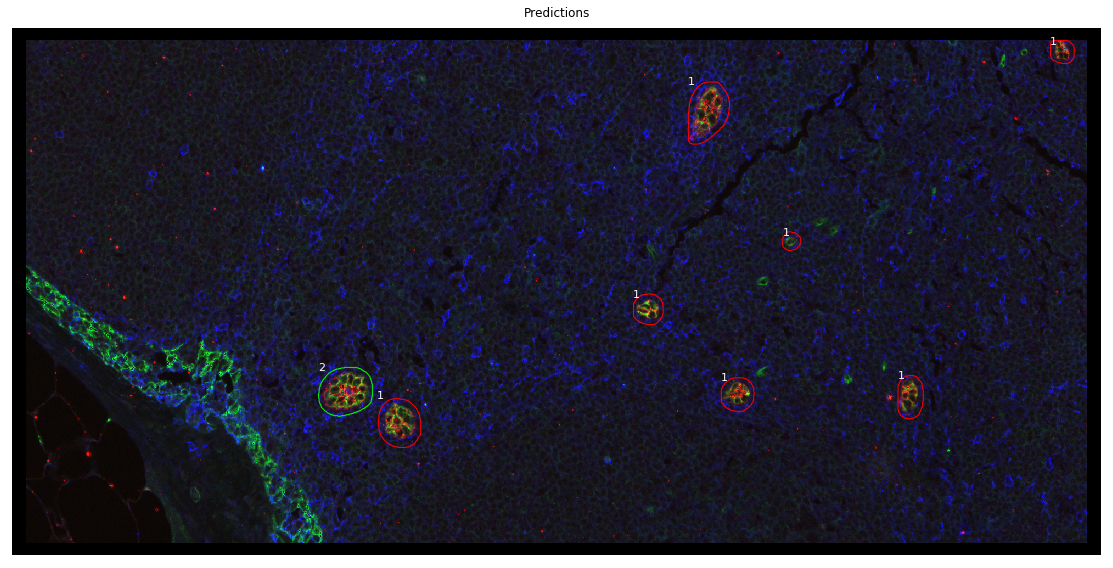

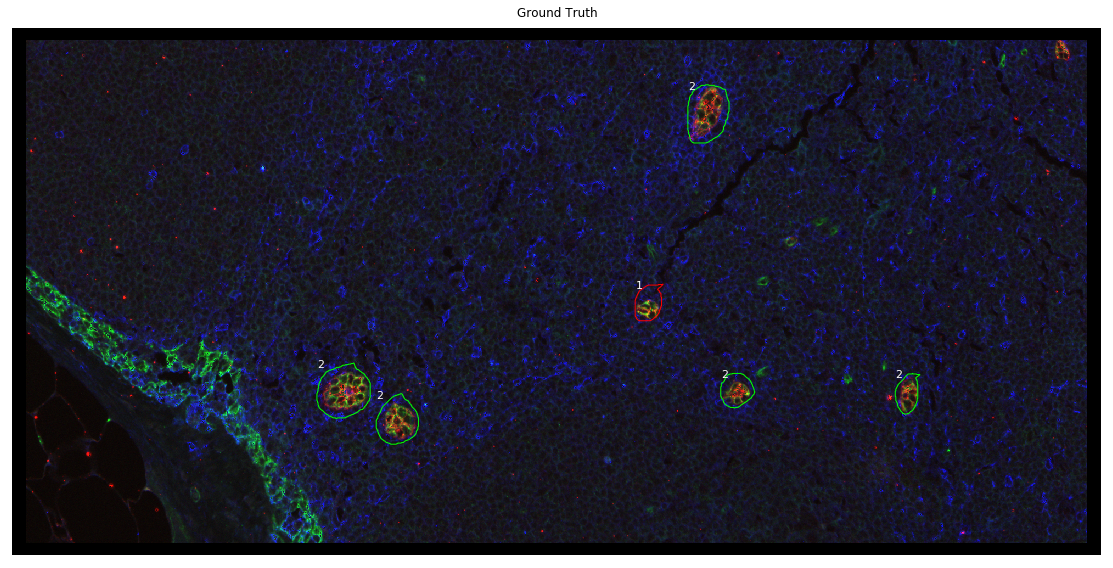

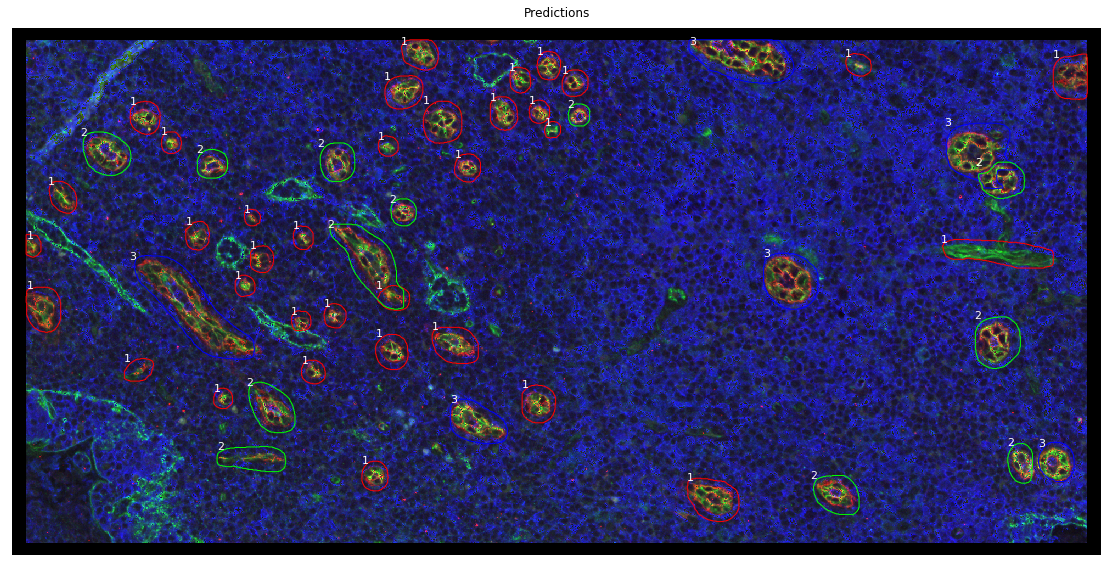

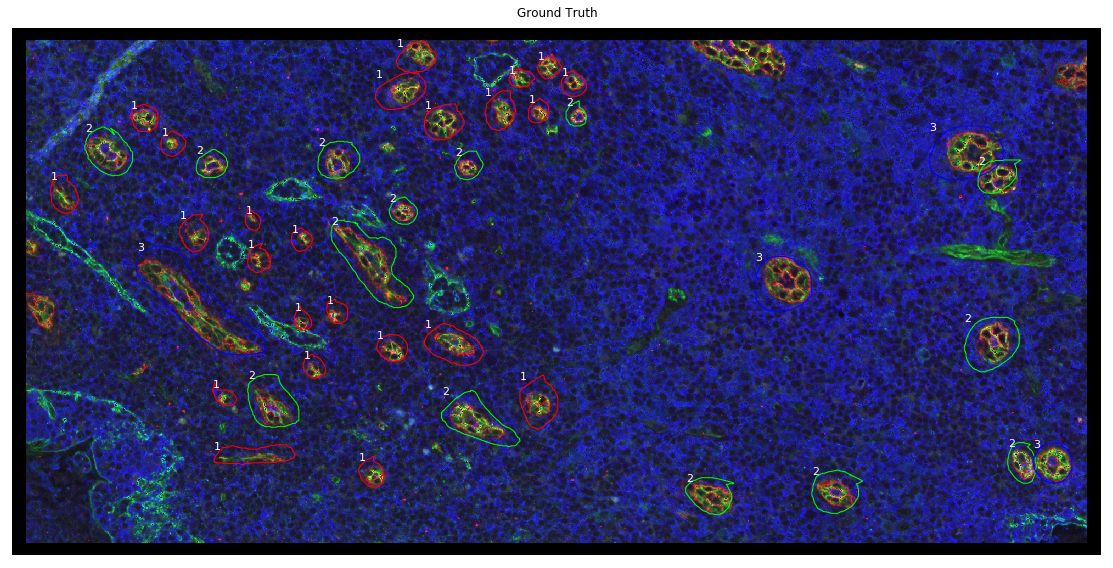

In [35]:
confusion = np.zeros((3,4)).astype(np.uint16)
image_ids = random.sample(list(dataset.image_ids), 2)
for image_id in image_ids:
    config.USE_MINI_MASK=False
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)
    info = dataset.image_info[image_id]

    # Run object detection
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=0)

    # Display results
    r = results[0]
    overlaps = utils.compute_overlaps_masks(r['masks'], gt_mask)
    predictions = count_prediction(gt_class_id, r['class_ids'],
                  overlaps, dataset.class_names, threshold=0.5)
    confusion += predictions

    # Display predictions only
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                 dataset.class_names, r['scores'], ax=get_ax(1),
                                 show_bbox=False, show_mask=False,
                                 title="Predictions", captions=r['class_ids'], score_threshold=0.1)

    # Display Ground Truth only
    visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                                 dataset.class_names, ax=get_ax(1),
                                 show_bbox=False, show_mask=False,
                                 title="Ground Truth", captions=gt_class_id)
print (confusion)
cm = np.around(100*confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis], decimals=1)
print (cm)